# Your $1^{st}$ Agent: Code generation and Execution

In [1]:
%matplotlib inline

## Setup Proxy and LLM Client

In [2]:
import os

# DWD proxy
os.environ["HTTP_PROXY"]  = "http://ofsquid.dwd.de:8080"
os.environ["HTTPS_PROXY"] = "http://ofsquid.dwd.de:8080"

# Optional but recommended
os.environ["http_proxy"]  = os.environ["HTTP_PROXY"]
os.environ["https_proxy"] = os.environ["HTTPS_PROXY"]

In [3]:
# Cell 1: Load .env and set up OpenAI
import os
from dotenv import load_dotenv
import openai

load_dotenv()

client = openai.Client(api_key=os.getenv("OPENAI_API_KEY"))

## Get latest ICON-D2 forecast files for T2M

In [4]:
"""
This code cell queries the DWD open data directory for ICON-D2 2 m temperature forecasts
and determines the most recent available file.

What it does step by step:
1. Downloads the HTML directory listing from the ICON-D2 t_2m endpoint.
2. Parses all file links using BeautifulSoup.
3. Filters files matching the ICON-D2 2 m temperature naming convention:
   icon-d2_germany_icosahedral_single-level_YYYYMMDDHH_XXX_2d_t_2m.grib2.bz2
4. Extracts the forecast reference timestamp (YYYYMMDDHH) from each filename.
5. Selects the file with the latest timestamp.
6. Prints the full download URL of that latest file.

The result can be used directly to download and process the newest ICON-D2
2 m temperature GRIB2 file.
"""

import requests
import re
from bs4 import BeautifulSoup
from urllib.parse import urljoin

base_url = "https://opendata.dwd.de/weather/nwp/icon-d2/grib/00/t_2m/"

# fetch directory listing
resp = requests.get(base_url)
resp.raise_for_status()

soup = BeautifulSoup(resp.text, "lxml")

# pattern for ICON-D2 2m temperature files
pattern = re.compile(
    r"icon-d2_germany_icosahedral_single-level_(\d{10})_\d{3}_2d_t_2m\.grib2\.bz2"
)

files = []

for link in soup.find_all("a"):
    href = link.get("href", "")
    m = pattern.match(href)
    if m:
        timestamp = m.group(1)  # YYYYMMDDHH
        files.append((timestamp, href))

if not files:
    raise RuntimeError("No matching ICON-D2 t_2m files found")

# select latest by timestamp
latest_timestamp, latest_file = max(files, key=lambda x: x[0])
latest_url = urljoin(base_url, latest_file)

print("Latest ICON-D2 2m temperature file:")
print(latest_url)


Latest ICON-D2 2m temperature file:
https://opendata.dwd.de/weather/nwp/icon-d2/grib/00/t_2m/icon-d2_germany_icosahedral_single-level_2025123100_000_2d_t_2m.grib2.bz2


## Setup code generation function

In [18]:
# Generate and save code 
def get_code_from_llm(prompt):
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "system", "content": "You are an AI coder. Provide only executable Python code — no markdown or explanation."},
            {"role": "user", "content": prompt}
        ]
    )
    return response.choices[0].message.content.strip()

prompt = f"""Give me code to download the file from
{latest_url}, decompress the .bz2 file and use the `eccodes` Python package to list all available keys in the first GRIB message.
Only print keys, do not access unknown keys directly. Return python code only."""

code = get_code_from_llm(prompt)

# Remove Markdown-style code fences if present
if code.startswith("```"):
    code = "\n".join(code.splitlines()[1:-1])

with open("download_dwd.py", "w") as f:
    f.write(code)

print("Generated and saved code:")
print(code)

Generated and saved code:
import requests
import bz2
import tempfile
from eccodes import GribFile, codes_index_get

# Download the .bz2 file
url = "https://opendata.dwd.de/weather/nwp/icon-d2/grib/00/t_2m/icon-d2_germany_icosahedral_single-level_2025123100_000_2d_t_2m.grib2.bz2"
response = requests.get(url)

# Save and decompress the .bz2 file
with tempfile.NamedTemporaryFile(delete=False) as temp_file:
    temp_file.write(response.content)
    temp_file.seek(0)
    decompressed_data = bz2.decompress(temp_file.read())

# Write decompressed data to a temporary file
with tempfile.NamedTemporaryFile(delete=False) as decompressed_file:
    decompressed_file.write(decompressed_data)
    decompressed_file_path = decompressed_file.name

# Use eccodes to read the GRIB file and list all keys in the first message
with GribFile(decompressed_file_path) as f:
    message = f.next()
    keys = codes_index_get(message, 'parameterName')
    for key in keys:
        print(key)


In [19]:
# Check outputs, latest files last 
!ls -ltrh

total 41688
-rw-r--r--@ 1 rpotthas  fe1    25K 25 Nov. 09:40 dawid_graph.py
drwxr-xr-x  5 rpotthas  fe1   160B 25 Nov. 09:40 downloads
-rw-r--r--@ 1 rpotthas  fe1    65B 25 Nov. 09:40 f_function.py
-rw-r--r--  1 rpotthas  fe1   603B 25 Nov. 09:40 generated.py
-rw-r--r--  1 rpotthas  fe1   541B 25 Nov. 09:40 plot_function.py
-rw-r--r--@ 1 rpotthas  fe1   513K 25 Nov. 09:40 temperature_forecast.png
-rw-r--r--  1 rpotthas  fe1   146B 31 Dez. 10:43 file.grib2.bz2
-rw-r--r--  1 rpotthas  fe1   146B 31 Dez. 10:44 icon-d2_germany_icosahedral_single-level_2025051000_000_2d_t_2m.grib2.bz2
-rw-r--r--  1 rpotthas  fe1     0B 31 Dez. 10:44 icon-d2_germany_icosahedral_single-level_2025051000_000_2d_t_2m.grib2
-rw-r--r--  1 rpotthas  fe1   146B 31 Dez. 10:44 icon-d2_grib_file.grib2.bz2
-rw-r--r--  1 rpotthas  fe1     0B 31 Dez. 10:44 icon-d2_grib_file.grib2
-rw-r--r--  1 rpotthas  fe1   776K 31 Dez. 10:45 file.bz2
-rw-r--r--  1 rpotthas  fe1   1,1M 31 Dez. 10:45 file.grib2
-rw-r--r--  1 rpotthas  fe

## Execute generated code

In [20]:
import traceback

try:
    exec(open("download_dwd.py").read())
except Exception as e:
    print("❌ Error during execution of download_dwd.py:")
    traceback.print_exc()

❌ Error during execution of download_dwd.py:


Traceback (most recent call last):
  File "/var/folders/4d/v62x5gg540g5q0n2_dmlyd60000c0j/T/ipykernel_13504/2130651293.py", line 4, in <module>
    exec(open("download_dwd.py").read())
  File "<string>", line 4, in <module>
ImportError: cannot import name 'GribFile' from 'eccodes' (/Users/rpotthas/ropy/lib/python3.12/site-packages/eccodes/__init__.py)


## Prepare functions for code generation and execution

In [21]:
import traceback
import openai
import os

client = openai.Client(api_key=os.getenv("OPENAI_API_KEY"))

def get_code_from_llm(prompt):
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "system", "content": "You are an AI coder. Output ONLY Python code that can be saved directly. No markdown formatting, no explanations."},
            {"role": "user", "content": prompt}
        ]
    )
    code = response.choices[0].message.content.strip()
    # Strip markdown fences if present
    if code.startswith("```"):
        code = "\n".join(code.splitlines()[1:-1])
    return code

def run_generated_code(code, filename="llm_generated.py"):
    with open(filename, "w") as f:
        f.write(code)
    print(f"\n🔧 Saved to {filename}")
    try:
        print("\n▶️ Running code...\n")
        exec_globals = {}
        exec(open(filename).read(), exec_globals)
        return True, None
    except Exception as e:
        tb = traceback.format_exc()
        print("❌ Error during execution:\n", tb)
        return False, tb


## Manual loop for feedback

In [27]:
prompt = f"""Download the file from
{latest_url}. Decompress the .bz2 file and print basic info about the GRIB file using the eccodes library.
Use: from eccodes import codes_grib_new_from_file, codes_get, codes_release
List the available GRIB keys in the first message and print a few safe ones like shortName, level. Save the file in data.grib2"""

MAX_TRIES = 5
current_prompt = prompt

for attempt in range(1, MAX_TRIES + 1):
    print(f"\n=== Attempt {attempt} ===")
    code = get_code_from_llm(current_prompt)
    success, error = run_generated_code(code)
    if success:
        print("\n✅ Code executed successfully.")
        break
    else:
        # Append traceback to the prompt for next try
        current_prompt = prompt + f"\n\nThe previous attempt failed with this error:\n{error}\n\nPlease fix the problem and provide corrected code."



=== Attempt 1 ===

🔧 Saved to llm_generated.py

▶️ Running code...

shortName: 2t
level: 2
dataDate: 20251231
dataTime: 0
forecastTime: 0
units: K
cfVarName: t2m
name: 2 metre temperature
typeOfLevel: heightAboveGround

✅ Code executed successfully.


In [28]:
!ls -ltr

total 36272
-rw-r--r--@ 1 rpotthas  fe1    25250 25 Nov. 09:40 dawid_graph.py
drwxr-xr-x  5 rpotthas  fe1      160 25 Nov. 09:40 downloads
-rw-r--r--@ 1 rpotthas  fe1       65 25 Nov. 09:40 f_function.py
-rw-r--r--  1 rpotthas  fe1      603 25 Nov. 09:40 generated.py
-rw-r--r--  1 rpotthas  fe1      541 25 Nov. 09:40 plot_function.py
-rw-r--r--@ 1 rpotthas  fe1   525586 25 Nov. 09:40 temperature_forecast.png
-rw-r--r--  1 rpotthas  fe1      146 31 Dez. 10:43 file.grib2.bz2
-rw-r--r--  1 rpotthas  fe1      146 31 Dez. 10:44 icon-d2_germany_icosahedral_single-level_2025051000_000_2d_t_2m.grib2.bz2
-rw-r--r--  1 rpotthas  fe1        0 31 Dez. 10:44 icon-d2_germany_icosahedral_single-level_2025051000_000_2d_t_2m.grib2
-rw-r--r--  1 rpotthas  fe1      146 31 Dez. 10:44 icon-d2_grib_file.grib2.bz2
-rw-r--r--  1 rpotthas  fe1        0 31 Dez. 10:44 icon-d2_grib_file.grib2
-rw-r--r--  1 rpotthas  fe1   795016 31 Dez. 10:45 file.bz2
-rw-r--r--  1 rpotthas  fe1  1118068 31 Dez. 10:45 file.grib2


In [29]:
cat llm_generated.py

import os
import bz2
import requests
from eccodes import codes_grib_new_from_file, codes_get, codes_release

# Download the file
url = "https://opendata.dwd.de/weather/nwp/icon-d2/grib/00/t_2m/icon-d2_germany_icosahedral_single-level_2025123100_000_2d_t_2m.grib2.bz2"
compressed_file_path = "data.grib2.bz2"
decompressed_file_path = "data.grib2"

response = requests.get(url)
with open(compressed_file_path, 'wb') as f:
    f.write(response.content)

# Decompress the .bz2 file
with bz2.BZ2File(compressed_file_path, 'rb') as file:
    with open(decompressed_file_path, 'wb') as new_file:
        new_file.write(file.read())

# Remove the compressed file
os.remove(compressed_file_path)

# Print basic info about the GRIB file
with open(decompressed_file_path, 'rb') as f:
    gid = codes_grib_new_from_file(f)
    if gid is not None:
        keys = [
            "shortName", "level", "dataDate", "dataTime", "forecastTime",
            "units", "cfVarName", "name", "typeOfLevel"
        ]
        

## Testing some functions to give them as templates

In [30]:
from eccodes import codes_grib_new_from_file, codes_get, codes_release

filename = "data.grib2"
shortnames = set()

with open(filename, "rb") as f:
    while True:
        try:
            gid = codes_grib_new_from_file(f)
            if gid is None:
                break
            shortname = codes_get(gid, "shortName")
            if shortname not in shortnames:
                print("-", shortname)
                shortnames.add(shortname)
            codes_release(gid)
        except Exception as e:
            print("⚠️ Error reading GRIB message:", e)
            break

- 2t


## Execution Loop as Function

In [12]:
from IPython.display import display, Markdown

def llm_code_execution_loop(prompt, max_tries=5, filename="llm_generated.py"):
    """
    Repeatedly calls LLM to generate code and runs it, feeding back errors until it succeeds or max_tries is reached.

    Parameters:
    - prompt (str): The user prompt for the LLM.
    - max_tries (int): Maximum number of attempts.
    - filename (str): Filename to save the generated code.

    Returns:
    - (success, final_code): Tuple with success flag and final generated code.
    """
    current_prompt = prompt
    final_code = ""

    for attempt in range(1, max_tries + 1):
        print(f"\n=== Attempt {attempt} ===")
        code = get_code_from_llm(current_prompt)
        final_code = code  # save final code for return
        
        # Force main() call in notebooks if it's defined
        if "def main()" in code and "main()" not in code:
            final_code += "\n\nmain()\n"
    
        # ✅ Show generated code in a Markdown code block
        display(Markdown(f"```\n{code}\n```"))
    
        success, error = run_generated_code(code, filename=filename)
        if success:
            print(f"\n✅ Code in {filename} executed successfully.")
            return True, final_code
        else:
            current_prompt = prompt + f"\n\nThe last run failed with this error:\n{error}\n\nPlease fix and regenerate valid Python code."

    print(f"\n❌ Failed after {max_tries} attempts.")
    return False, final_code


## Testing on Download

In [13]:
prompt = f"""Download the files 
https://opendata.dwd.de/weather/nwp/icon-d2/grib/00/clat/icon-d2_germany_icosahedral_time-invariant_2025123100_000_0_clat.grib2.bz2 
and 
https://opendata.dwd.de/weather/nwp/icon-d2/grib/00/clon/icon-d2_germany_icosahedral_time-invariant_2025123100_000_0_clon.grib2.bz2. 
Decompress the .bz2 file save it as clat.grib2 and clon.grib2."""

success, final_code = llm_code_execution_loop(prompt, max_tries=5, filename="download_clat_clon_D2.py")



=== Attempt 1 ===


```
import urllib.request
import bz2

# Define the URLs
clat_url = "https://opendata.dwd.de/weather/nwp/icon-d2/grib/00/clat/icon-d2_germany_icosahedral_time-invariant_2025123100_000_0_clat.grib2.bz2"
clon_url = "https://opendata.dwd.de/weather/nwp/icon-d2/grib/00/clon/icon-d2_germany_icosahedral_time-invariant_2025123100_000_0_clon.grib2.bz2"

# Download the files
clat_bz2 = "clat.grib2.bz2"
clon_bz2 = "clon.grib2.bz2"
urllib.request.urlretrieve(clat_url, clat_bz2)
urllib.request.urlretrieve(clon_url, clon_bz2)

# Decompress the .bz2 files
with bz2.open(clat_bz2, 'rb') as f_in:
    with open("clat.grib2", 'wb') as f_out:
        f_out.write(f_in.read())

with bz2.open(clon_bz2, 'rb') as f_in:
    with open("clon.grib2", 'wb') as f_out:
        f_out.write(f_in.read())
```


🔧 Saved to download_clat_clon_D2.py

▶️ Running code...


✅ Code in download_clat_clon_D2.py executed successfully.


## Checking File Contents

In [31]:
from eccodes import codes_grib_new_from_file, codes_get, codes_get_array, codes_release
import numpy as np

def read_2t_from_data_grib2(filename="data.grib2"):
    with open(filename, "rb") as f:
        gid = codes_grib_new_from_file(f)
        if gid is None:
            print("No GRIB message found.")
            return None
        shortname = codes_get(gid, "shortName")
        print("shortName:", shortname)
        values = codes_get_array(gid, "values")
        codes_release(gid)
        return np.array(values)

t2m = read_2t_from_data_grib2()
print("✅ Loaded:", t2m.shape)
print("Min:", np.min(t2m), "Max:", np.max(t2m))

shortName: 2t
✅ Loaded: (542040,)
Min: 251.3883514404297 Max: 9999.0


## Testing the Code Generation and Execution of Plotting ICON-D2

In [32]:
template = """
from eccodes import codes_grib_new_from_file, codes_get, codes_release

filename = "data.grib2"
shortnames = set()

with open(filename, "rb") as f:
    while True:
        try:
            gid = codes_grib_new_from_file(f)
            if gid is None:
                break
            shortname = codes_get(gid, "shortName")
            if shortname not in shortnames:
                print("-", shortname)
                shortnames.add(shortname)
            codes_release(gid)
        except Exception as e:
            print("⚠️ Error reading GRIB message:", e)
            break
"""

prompt = f"""The following template works:\n{template}\n\n
Now write a complete Python script using only `eccodes` to extract and plot temperature data:

- Read from three GRIB2 files:
  - `clat.grib2` contains latitude values (`shortName="tlat"`)
  - `clon.grib2` contains longitude values (`shortName="tlon"`)
  - `data.grib2` contains 2m temperature (`shortName="2t"`)

- For each file, find the message with the correct `shortName` and extract values using `codes_get_array`.
- Convert the temperature from Kelvin to Celsius.
- Filter out all temperature values outside the range [-10, 50] °C, and apply the same mask to lat/lon.
- Create a 2D scatter plot using `matplotlib`, with:
  - x = tlon
  - y = tlat
  - color = 2t
  - point size = 1
- Use `cartopy` to:
  - Add country borders
  - Add rivers
  - Add the land-sea mask as a visible black outline
- Include a colorbar scaled to the figure
- Save the resulting figure as `t2m.png`
- Output **only valid and executable Python code** (no markdown or explanation).
"""

success, final_code = llm_code_execution_loop(prompt, max_tries=5, filename="plot_dwd.py")


=== Attempt 1 ===


```
from eccodes import codes_grib_new_from_file, codes_get, codes_get_array, codes_release
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def read_grib_data(filename, shortname):
    with open(filename, "rb") as f:
        while True:
            gid = codes_grib_new_from_file(f)
            if gid is None:
                break
            try:
                if codes_get(gid, "shortName") == shortname:
                    data = codes_get_array(gid, "values")
                    codes_release(gid)
                    return data
            except Exception as e:
                print("Error reading GRIB message:", e)
                codes_release(gid)
                break
    return None

# Reading data from GRIB2 files
latitudes = read_grib_data("clat.grib2", "tlat")
longitudes = read_grib_data("clon.grib2", "tlon")
temperatures_k = read_grib_data("data.grib2", "2t")

if latitudes is None or longitudes is None or temperatures_k is None:
    print("Error retrieving data from GRIB files.")
    exit(1)

# Convert temperatures from Kelvin to Celsius
temperatures_c = temperatures_k - 273.15

# Mask out temperatures outside the range [-10, 50] Celsius
mask = (temperatures_c >= -10) & (temperatures_c <= 50)
latitudes = latitudes[mask]
longitudes = longitudes[mask]
temperatures_c = temperatures_c[mask]

# Create scatter plot
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
sc = ax.scatter(longitudes, latitudes, c=temperatures_c, cmap='jet', s=1, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.RIVERS)
ax.add_feature(cfeature.LAND, edgecolor='black')

# Add colorbar
cbar = plt.colorbar(sc, orientation='vertical', pad=0.05)
cbar.set_label('2m Temperature (°C)')

# Save plot
plt.savefig("t2m.png", dpi=300)
plt.close(fig)
```


🔧 Saved to plot_dwd.py

▶️ Running code...


✅ Code in plot_dwd.py executed successfully.


## Show Image, if generated

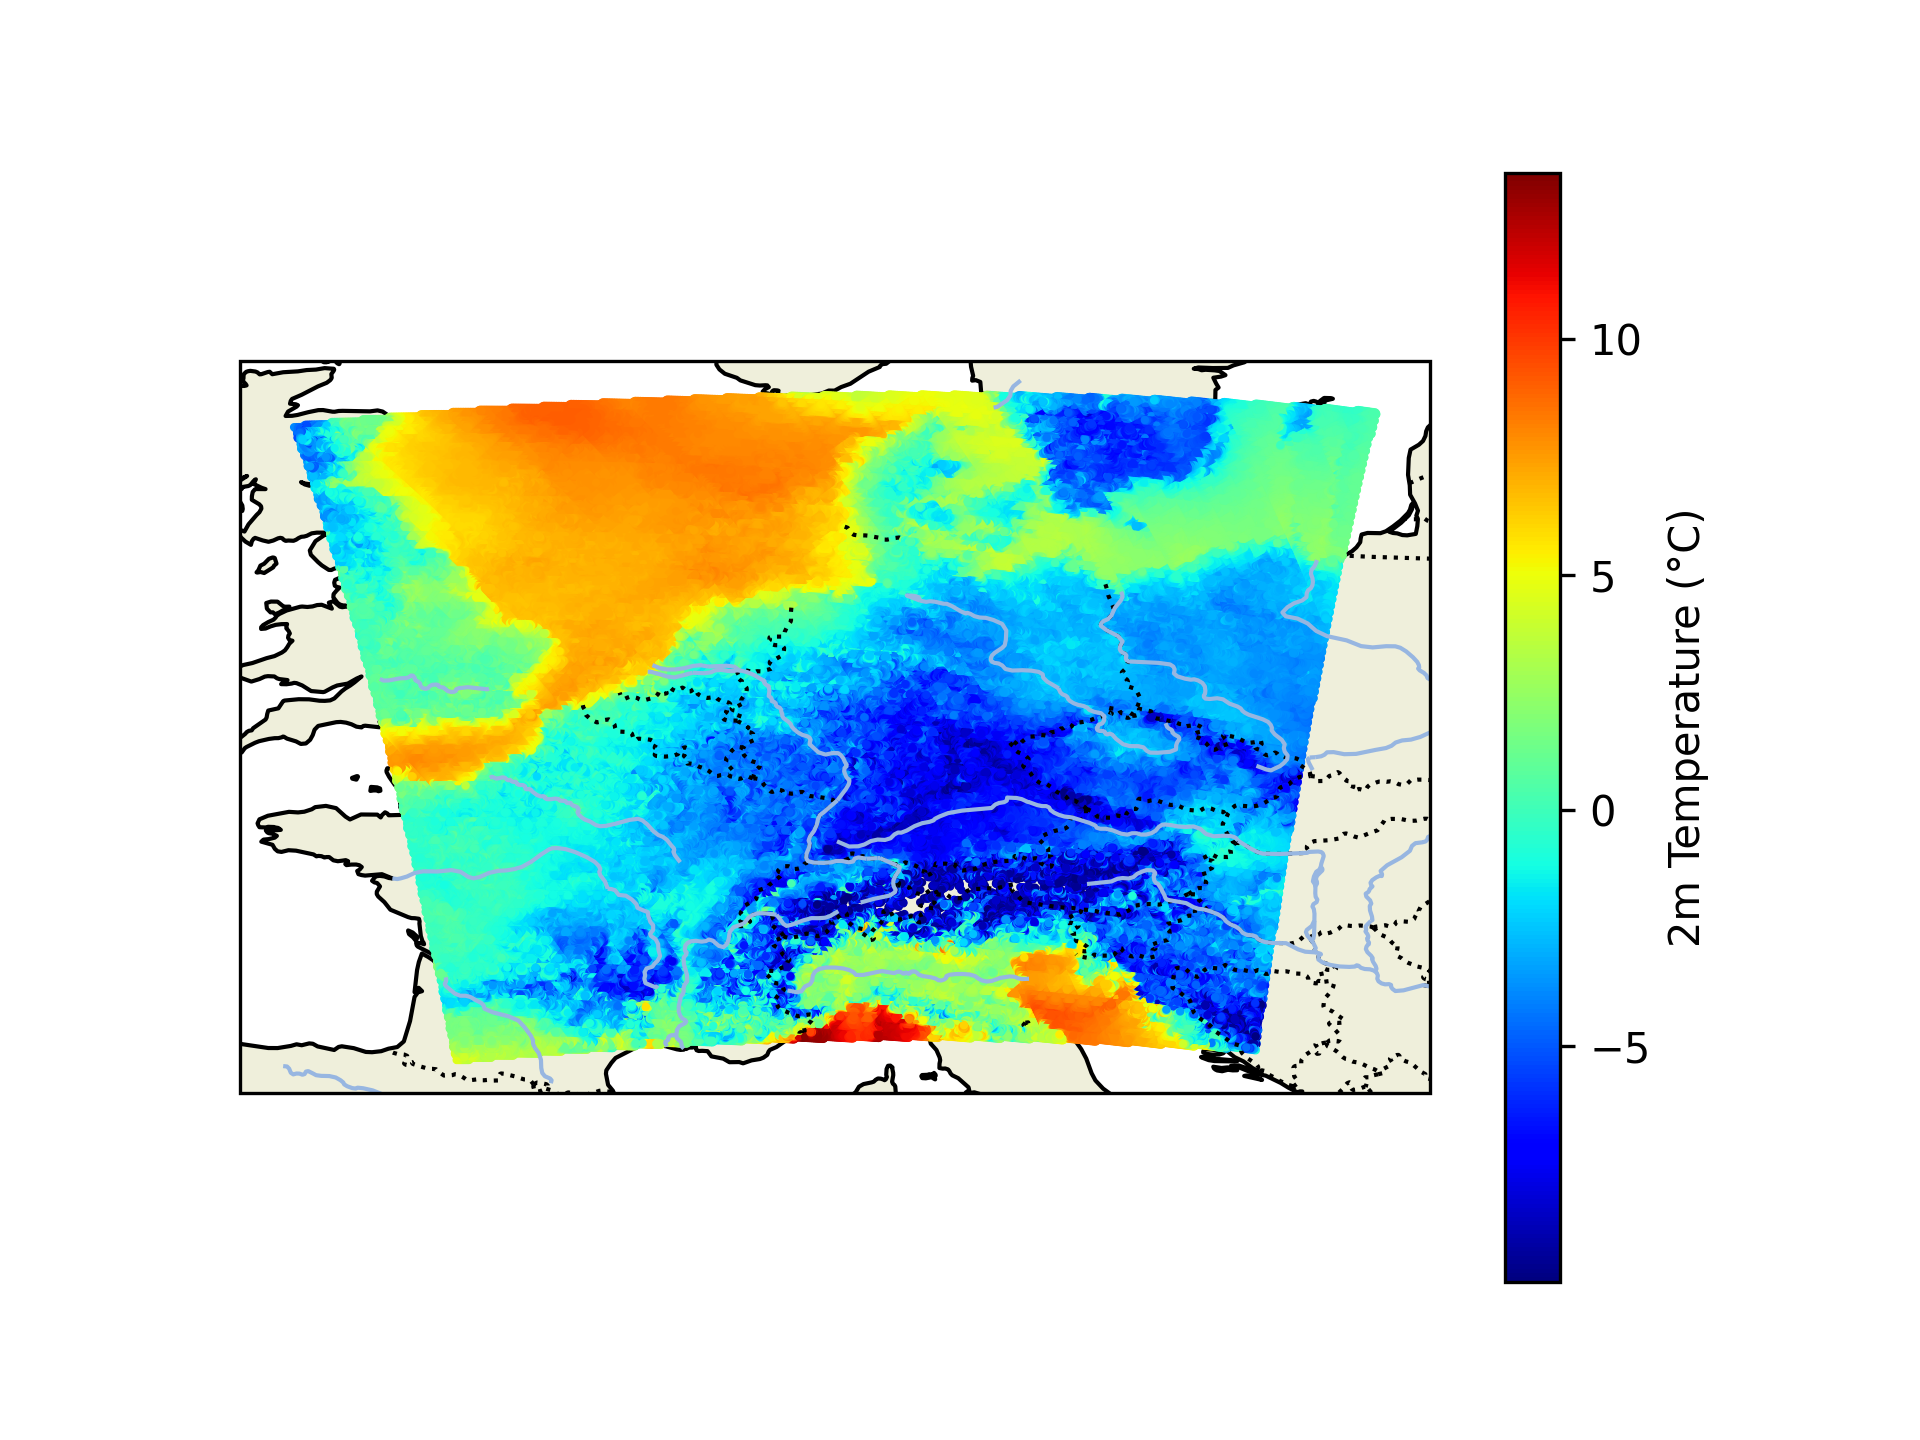

In [33]:
from IPython.display import Image, display
if os.path.exists("t2m.png"):
        display(Image("t2m.png", width=500))

## My own Version of Plotting for Comparison

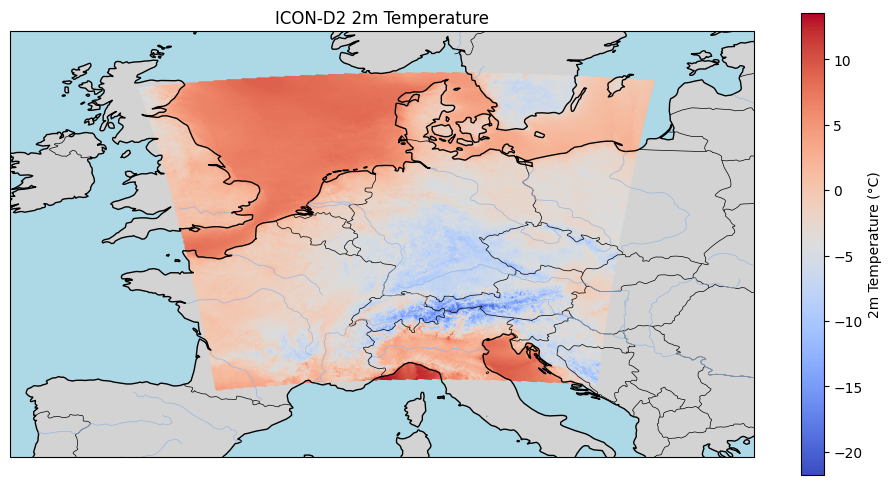

In [34]:
from eccodes import codes_grib_new_from_file, codes_get, codes_get_array, codes_release
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from IPython.display import Image, display
import os

def read_grib_by_shortname(filename, shortname):
    with open(filename, "rb") as f:
        while True:
            gid = codes_grib_new_from_file(f)
            if gid is None:
                break
            if codes_get(gid, "shortName") == shortname:
                values = codes_get_array(gid, "values")
                codes_release(gid)
                return np.array(values)
            codes_release(gid)
    print(f"❌ {shortname} not found in {filename}")
    return None

# Load data with actual shortNames
clat = read_grib_by_shortname("clat.grib2", "tlat")
clon = read_grib_by_shortname("clon.grib2", "tlon")
t2m  = read_grib_by_shortname("file.grib2", "2t")

if clat is None or clon is None or t2m is None:
    print("❌ Failed to load one or more variables.")
else:
    # Convert to Celsius and mask extreme values
    t2m_c = t2m - 273.15
    t2m_c = np.where((t2m_c < -50) | (t2m_c > 50), np.nan, t2m_c)

    # Geographic filter
    mask = (clon >= -10) & (clon <= 50) & (clat >= 30) & (clat <= 75)
    clat = clat[mask]
    clon = clon[mask]
    t2m_c = t2m_c[mask]

    # Plot
    plt.figure(figsize=(12, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-10, 25, 40, 60], crs=ccrs.PlateCarree())

    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.add_feature(cfeature.RIVERS, linewidth=0.5)
    ax.add_feature(cfeature.LAND, facecolor="lightgray")
    ax.add_feature(cfeature.OCEAN, facecolor="lightblue")

    sc = ax.scatter(clon, clat, c=t2m_c, cmap="coolwarm", s=1, edgecolors='none', transform=ccrs.PlateCarree())
    plt.colorbar(sc, label="2m Temperature (°C)")
    plt.title("ICON-D2 2m Temperature")

    plt.savefig("t2m_template.png", dpi=300, bbox_inches="tight")
    plt.show()